In [1]:
#!/usr/bin/python3
from PIL import Image
import random
import torch
import numpy as np
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator


In [26]:
# load image filepaths
imageFiles = open("images.txt", "r")
images = []

for line in imageFiles.readlines():
    line = line.strip()
    filename = line.split("/")[-1]
    filenameNoExt = filename.split(".")[0]
    images.append([line, filename, filenameNoExt])

In [5]:
imageFile = "sa_223795"
image = Image.open(r"/home/brian/Projects/CSCI_7000-data/images/" + imageFile + ".jpg")
width, height = image.size

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if 'cuda' in device else torch.float32
model_type = 'vit_h'
checkpoint = '../model_checkpoints/sam_vit_h_4b8939.pth'

# SAM initialization
model = sam_model_registry[model_type](checkpoint = checkpoint)
model.to(device)
predictor = SamPredictor(model)
#mask_generator = SamAutomaticMaskGenerator(model)
predictor.set_image(np.array(image)) # load the image to predictor

input point:  [[784 825]]


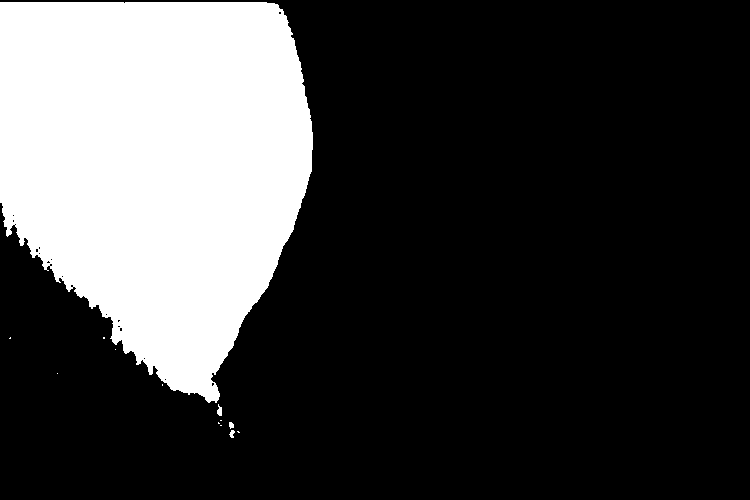

In [18]:
inx = random.randint(0, width)
iny = random.randint(0, height)

input_point = np.array([[inx, iny]])
input_label = np.array([1])

print("input point: ", input_point)

masks, scores, logits = predictor.predict(point_coords = input_point, point_labels = input_label)
masks = masks[0, ...]
bitmaskImage = Image.fromarray(masks)
display(bitmaskImage.resize(((width // 3, height // 3))))
bitmaskImage.save("../data/" + imageFile + "_bitmask.jpg")

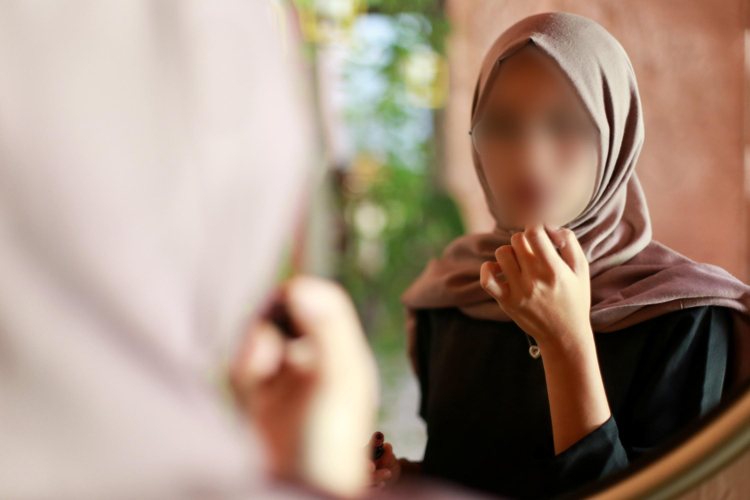

In [19]:
# mask and crop the image

crop_mode = "w_bg" # Optional['wo_bg', 'w_bg'], where w_bg and wo_bg refer to remain and discard background separately.

if crop_mode == "wo_bg":
    masked_image = image * masks[:,:,np.newaxis] + (1 - masks[:,:,np.newaxis]) * 255
    masked_image = np.uint8(masked_image)
else:
    masked_image = np.array(image)
masked_image = Image.fromarray(masked_image)

display(masked_image.resize((width // 3, height // 3)))

0.0 0.0026666666666666666 0.41688888888888886 0.584


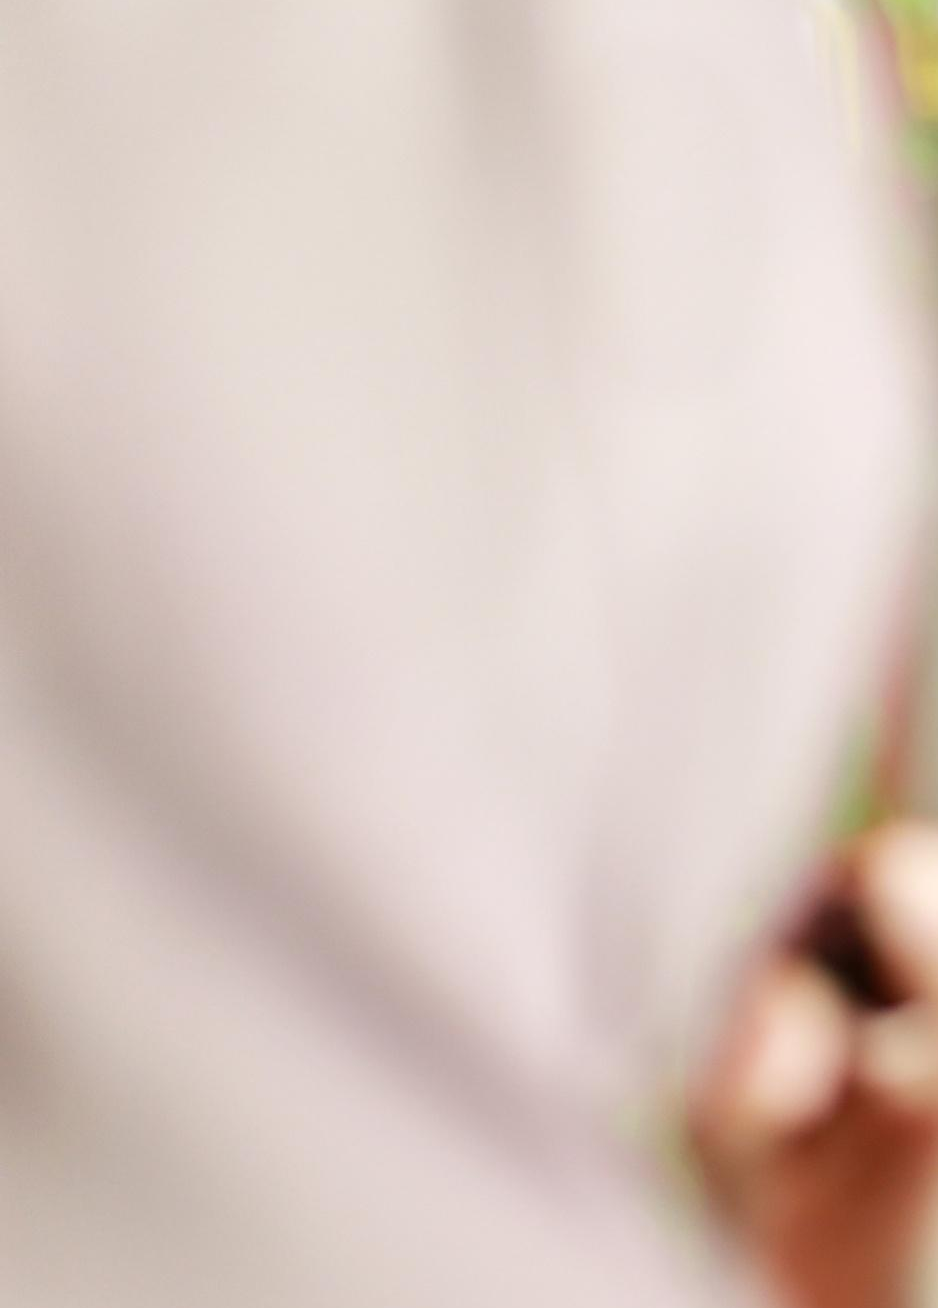

In [20]:
def boundary(inputs):
    
    col = inputs.shape[1]
    inputs = inputs.reshape(-1)
    lens = len(inputs)
    start = np.argmax(inputs)
    end = lens - 1 - np.argmax(np.flip(inputs))
    top = start // col
    bottom = end // col
    
    return top, bottom

def seg_to_box(seg_mask, size):
    
    top, bottom = boundary(seg_mask)
    left, right = boundary(seg_mask.T)
    left, top, right, bottom = left / size, top / size, right / size, bottom / size # we normalize the size of boundary to 0 ~ 1

    return [left, top, right, bottom]

size = max(masks.shape[0], masks.shape[1])
left, top, right, bottom = seg_to_box(masks, size) # calculating the position of the top-left and bottom-right corners in the image
print(left, top, right, bottom)

image_crop = masked_image.crop((left * size, top * size, right * size, bottom * size)) # crop the image
display(image_crop)